#### Librerías necesarias

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from PIL import Image

# Ejercicio 1: Correlación

## A

In [ ]:
def extraer_pares_verticales(imagen):
    height, width = imagen.shape
    pares = []
    for i in range(0, height - 1, 2):
        for j in range(width):
            pixel_superior = imagen[i, j]
            pixel_inferior = imagen[i + 1, j]
            pares.append([pixel_superior, pixel_inferior])
    return np.array(pares)

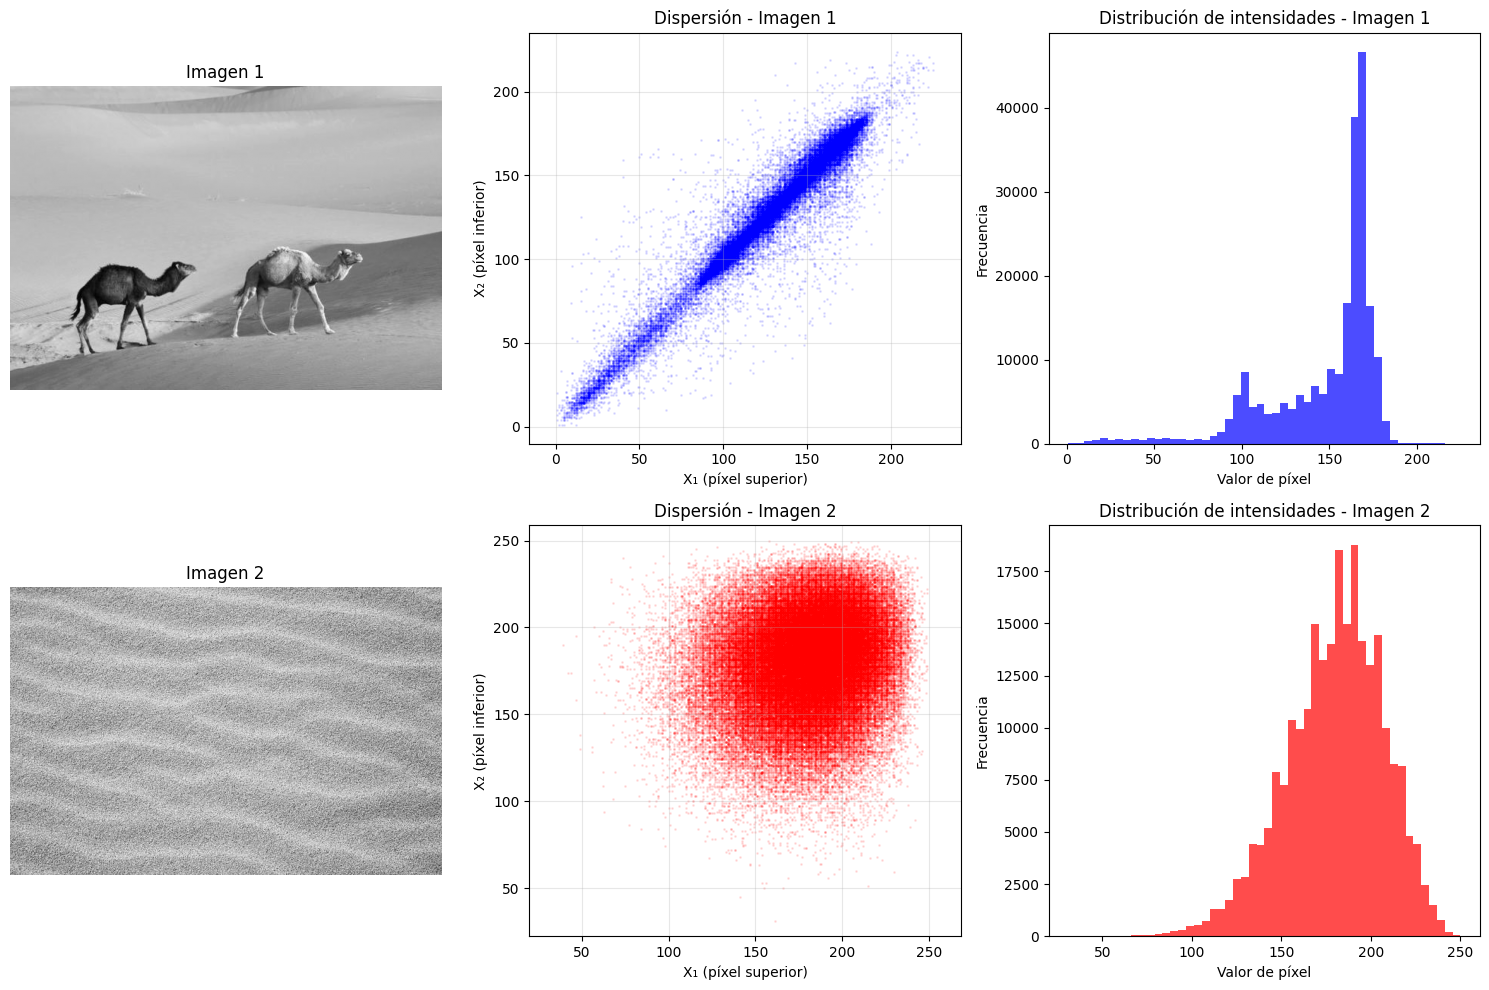

In [ ]:
# Cargar las imágenes y convertirlas a escala de grises y float
img1 = np.array(Image.open('imagenes/img_01.jpg').convert('L')).astype(float)
img2 = np.array(Image.open('imagenes/img_02.jpg').convert('L')).astype(float)

# Extraer pares para ambas imágenes
pares_img1 = extraer_pares_verticales(img1)
pares_img2 = extraer_pares_verticales(img2)

# Crear la figura con subplots
plt.figure(figsize=(15, 10))

# Mostrar imagen 1
plt.subplot(2, 3, 1)
plt.imshow(img1, cmap='gray')
plt.title('Imagen 1')
plt.axis('off')

# Scatter plot para imagen 1
plt.subplot(2, 3, 2)
plt.scatter(pares_img1[:, 0], pares_img1[:, 1], alpha=0.1, s=1, color='blue')
plt.title('Dispersión - Imagen 1')
plt.xlabel('X₁ (píxel superior)')
plt.ylabel('X₂ (píxel inferior)')
plt.grid(True, alpha=0.3)
plt.axis('equal')

# Histograma marginal para imagen 1
plt.subplot(2, 3, 3)
plt.hist(pares_img1.flatten(), bins=50, alpha=0.7, color='blue')
plt.title('Distribución de intensidades - Imagen 1')
plt.xlabel('Valor de píxel')
plt.ylabel('Frecuencia')

# Mostrar imagen 2
plt.subplot(2, 3, 4)
plt.imshow(img2, cmap='gray')
plt.title('Imagen 2')
plt.axis('off')

# Scatter plot para imagen 2
plt.subplot(2, 3, 5)
plt.scatter(pares_img2[:, 0], pares_img2[:, 1], alpha=0.1, s=1, color='red')
plt.title('Dispersión - Imagen 2')
plt.xlabel('X₁ (píxel superior)')
plt.ylabel('X₂ (píxel inferior)')
plt.grid(True, alpha=0.3)
plt.axis('equal')

# Histograma marginal para imagen 2
plt.subplot(2, 3, 6)
plt.hist(pares_img2.flatten(), bins=50, alpha=0.7, color='red')
plt.title('Distribución de intensidades - Imagen 2')
plt.xlabel('Valor de píxel')
plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

# Información adicional útil
# print(f"Dimensiones Imagen 1: {img1.shape}")
# print(f"Dimensiones Imagen 2: {img2.shape}")
# print(f"Número de pares verticales Imagen 1: {len(pares_img1)}")
# print(f"Número de pares verticales Imagen 2: {len(pares_img2)}")
# print(f"Rango de valores Imagen 1: [{img1.min():.1f}, {img1.max():.1f}]")
# print(f"Rango de valores Imagen 2: [{img2.min():.1f}, {img2.max():.1f}]")

## B

In [13]:
# Calcular correlación para cada imagen
def correlacion(pares):
    X1 = pares[:,0] # Extraer primera columna -> píxel de arriba
    X2 = pares[:,1] # Extraer segunda columna -> píxel de abajo
    return np.corrcoef(X1, X2)[0,1] # Armar la matriz de correlación 2x2 y agarrar la correlación entre X1 y X2

corr_img1 = correlacion(pares_img1)
corr_img2 = correlacion(pares_img2)

print(f"Coeficiente de correlación Imagen 1: {corr_img1:.4f}")
print(f"Coeficiente de correlación Imagen 2: {corr_img2:.4f}")

Coeficiente de correlación Imagen 1: 0.9792
Coeficiente de correlación Imagen 2: 0.1459


En la Imagen 1 obtuvimos un coeficiente de correlación cercano a uno, lo que muestra una fuerte relación lineal entre píxeles vecinos. En cambio, para la Imagen 2 el coeficiente fue más bajo, mostrando menor redundancia.
Esto nos dice que la Imagen 1 puede comprimirse con PCA manteniendo mayor calidad, ya que los píxeles contienen información más repetitiva.

## C

In [ ]:
# Aplicar PCA para desacoplar las variables de cada vector
def transformar_pca(pares):
    pca = PCA(n_components=2)
    return pca.fit_transform(pares)

# Transformar los pares de ambas imágenes
pares_img1_pca = transformar_pca(pares_img1)
pares_img2_pca = transformar_pca(pares_img2)


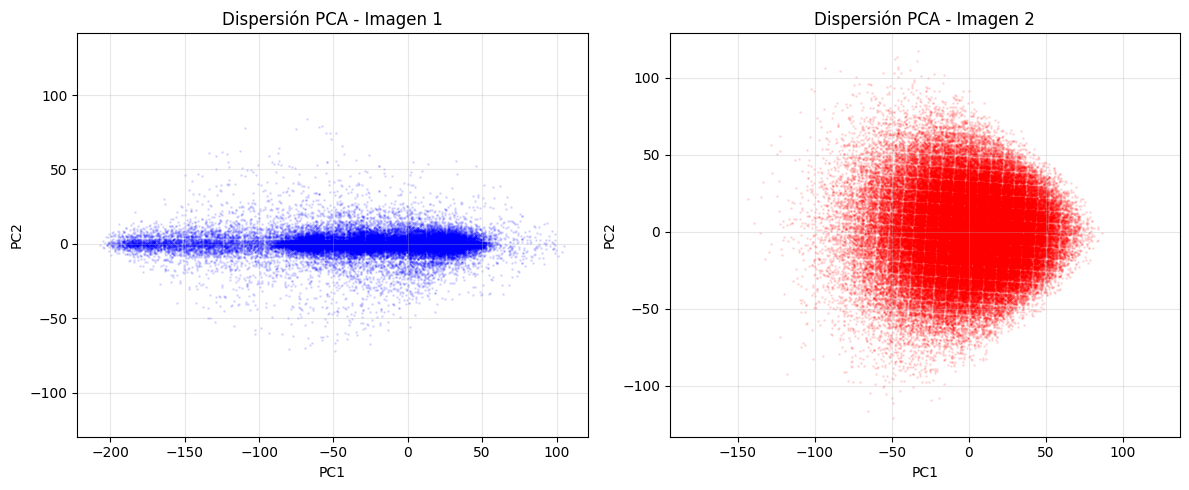

In [12]:
# Graficar dispersión de los vectores transformados
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(pares_img1_pca[:, 0], pares_img1_pca[:, 1], alpha=0.1, s=1, color='blue')
plt.title('Dispersión PCA - Imagen 1')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.axis('equal')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.scatter(pares_img2_pca[:, 0], pares_img2_pca[:, 1], alpha=0.1, s=1, color='red')
plt.title('Dispersión PCA - Imagen 2')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.axis('equal')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Después de la transformación, las nuevas variables (componentes principales) estarán desacopladas (correlación cercana a cero).
Esto se verá en los gráficos como una dispersión más "circular" o alineada con los ejes principales, mostrando que la redundancia entre píxeles vecinos ha sido eliminada.

# Ejercicio 2: Compresión

In [ ]:
def our_svd(x, n_samples):
    cov = (x.T @ x) / (n_samples - 1)

    # Calculamos autovalores y autovectores de la matriz de covarianza. Después los ordenamos de mayor a menor
    autovalues, V = np.linalg.eig(cov)

    idx = np.argsort(autovalues)[::-1]
    autovalues = autovalues[idx]
    V = V[:, idx]

    # 3. Calculamos los valores singulares en base a su relación teórica con los autovalores de la matriz de cov
    S = np.sqrt(autovalues*(n_samples - 1))

    # 4. Calculamos U (teniendo cuidado con no dividir por cero porque sino revienta)
    nonzero_idx = S > 1e-10
    U = (x @ V[:, nonzero_idx]) / S[nonzero_idx]

    return U, S, V, autovalues

def pca_transform(x, saving):
    n_samples = x.shape[0]

    # 1. Centramos los datos utilizando el vector de medias muestrales
    mu = np.mean(x, axis=0)
    x = x - mu[None, :]

    # 2. Hacemos SVD
    U, S, V, autovalues = our_svd(x, n_samples)
    
    # 3. Determinar k para lograr el ahorro deseado
    total_variance = np.sum(autovalues)
    cumulative_variance = np.cumsum(autovalues)
    target_variance = saving * total_variance  # Varianza a conservar
    k = np.sum(cumulative_variance <= target_variance) + 1
    if k > len(autovalues):
        k = len(autovalues)

    print(f"Componentes conservados: {k} / {len(autovalues)}")

    # 4. Proyectar a k dimensiones
    V_k = V[:, :k]
    x_compressed = x @ V_k

    # 5. Graficar autovalores (usamos escala logaritmica para poder visualizar mejor los datos)
    colors = ['blue' if i < k else 'red' for i in range(len(autovalues))]
    plt.figure(figsize=(10, 5))
    plt.bar(range(1, len(autovalues) + 1), autovalues, color=colors)
    plt.axvline(k + 0.5, color='green', linestyle='--', label=f'{saving*100:.0f}% varianza')
    plt.yscale('log')
    plt.xlabel('Componente principal')
    plt.ylabel('Autovalor (escala logarítmica)')
    plt.title('Autovalores de la matriz de covarianza (escala logarítmica)')
    plt.legend()
    plt.show()

    return x_compressed, V_k, mu

In [ ]:
def cut_img(img:np.array, n:int) -> np.array:
    h, w = img.shape

    h_cut = h - (h % n)
    w_cut = w - (w % n)

    #Dividimos a la mitad nuestro sobrante para eliminar de forma centrada el excedente (para evitar sesgos)
    start_h = (h - h_cut) // 2
    start_w = (w - w_cut) // 2

    return img[start_h:(start_h+h_cut), start_w:(start_w+w_cut)], h_cut, w_cut

def n_segmentation_img (img:np.array, n: int) -> np.array:
    img_cut, h, w = cut_img(img, n) #Recortamos la imagen para que sea divisible en cuadrados de nxn

    img_seg = []

    for i in range(0, h, n):
        for j in range(0, w, n):
                img_seg.append(img_cut[i:(i+n), j:(j+n)].flatten(order="F")) # Tomamos un cuadrado nxn y lo aplanamos por columnas

    return np.array(img_seg)

In [ ]:
img = np.array(Image.open('imagenes/img_03.jpg').convert('L')).astype(float)
x = n_segmentation_img(img, 8)

pca_transform(x, 0.8);

# Ejercicio 3: Descompresión